In [4]:
import sys
import os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

In [5]:
import numpy as np
import pandas as pd
# import umap

# from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

In [6]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(12,6),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [7]:
fname = "data/cleaned_CSF_AllSub.csv"
raw_data = pd.read_csv(fname)
raw_data.head()

,ASD_DX_group,Risk,Hippocampus right,Hippocampus left,Amygdala right,Amygdala left,Anterior temporal lobe - medial right,Anterior temporal lobe - medial part left,Anterior temporal lobe - lateral right,Anterior temporal lobe - lateral left,...,LeftCaudate,RightCaudate,LeftHippocapus,RightHippocapus,LeftGlobusPall,RightGlobusPall,LeftPutamen,RightPutamen,LeftThalamus,RightThalamus
0,TYPICAL,HR,327,124,138,178,794,691,663,637,...,2081,1987,1993,2071,781,783,2827,3068,5308,5483
1,ASD,HR,136,61,37,41,1183,1000,670,711,...,1687,1798,1630,1480,510,525,2321,2230,4497,4574
2,ASD,HR,283,142,56,81,1250,1261,851,876,...,2442,2399,2048,2249,764,777,3120,2966,5525,5478
3,TYPICAL,LR,183,137,63,62,1265,1237,789,826,...,2229,2303,1803,1847,692,709,2839,2754,4666,4741
4,TYPICAL,LR,262,92,57,78,1335,885,881,493,...,2365,2314,1722,1669,670,660,2701,2776,4870,4891


In [8]:
raw_data.shape

(380, 101)

In [9]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = ["WM", "GM"]

features = raw_data.drop(columns=noisy_cols+label_cols)
features.head()

,Hippocampus right,Hippocampus left,Amygdala right,Amygdala left,Anterior temporal lobe - medial right,Anterior temporal lobe - medial part left,Anterior temporal lobe - lateral right,Anterior temporal lobe - lateral left,Gyri parahippocampalis et ambiens right,Gyri parahippocampalis et ambiens left,...,LeftCaudate,RightCaudate,LeftHippocapus,RightHippocapus,LeftGlobusPall,RightGlobusPall,LeftPutamen,RightPutamen,LeftThalamus,RightThalamus
0,327,124,138,178,794,691,663,637,198,186,...,2081,1987,1993,2071,781,783,2827,3068,5308,5483
1,136,61,37,41,1183,1000,670,711,194,148,...,1687,1798,1630,1480,510,525,2321,2230,4497,4574
2,283,142,56,81,1250,1261,851,876,241,306,...,2442,2399,2048,2249,764,777,3120,2966,5525,5478
3,183,137,63,62,1265,1237,789,826,229,164,...,2229,2303,1803,1847,692,709,2839,2754,4666,4741
4,262,92,57,78,1335,885,881,493,197,254,...,2365,2314,1722,1669,670,660,2701,2776,4870,4891


In [10]:
labels = raw_data[label_cols].copy()
labels.head()

,ASD_DX_group,Risk
0,TYPICAL,HR
1,ASD,HR
2,ASD,HR
3,TYPICAL,LR
4,TYPICAL,LR


In [11]:
enc = OrdinalEncoder()
enc.fit(labels)
enc_labels = enc.transform(labels)
enc.categories_

[array(['ASD', 'ATYPICAL_ADOS', 'ATYPICAL_MULLEN', 'TYPICAL'], dtype=object),
 array(['HR', 'LR'], dtype=object)]

In [12]:
enc_labels[:5]

array([[3., 0.],
       [0., 0.],
       [0., 0.],
       [3., 1.],
       [3., 1.]])

In [13]:
risk_labels = pd.Series(enc_labels[:,1], dtype=int)
data = features.copy()

# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.1)

train_labels.value_counts()

0    227
1    115
dtype: int64

In [14]:
def build_dnn(num_features, num_labels, activation="elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.01 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    
    dnn.add(Dense(units = 50, activation=activation, input_dim=num_features,
                  kernel_initializer=keras.initializers.he_normal(), kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0.2))
    dnn.add(Dense(units = 25, activation=activation,
                  kernel_initializer=keras.initializers.he_normal(), kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0.2))
    
    dnn.add(Dense(units=num_labels, activation="sigmoid",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer="sgd",
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [15]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1)
dnn.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                4900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 6,201
Trainable params: 6,201
Non-trainable params: 0
_________________________________________________________________


/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/smaug/a

In [16]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
# from imblearn.over_sampling import SMOTE

smote=False

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)

if smote:
    print("Using SMOTE")
    X_train,y_train = SMOTE(random_state=RANDOM_STATE).fit_resample(X_train,np.ravel(y_train)) # Both are np arrays now
    y_train = y_train.reshape(-1,1)
    class_weight=None

dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid), class_weight=class_weight,
                  epochs=100, batch_size=10, verbose=1)


Train on 342 samples, validate on 38 samples
Epoch 1/100
342/342 [==============================] - 0s 395us/step - loss: 8.3873 - accuracy: 0.6316 - val_loss: 8.2241 - val_accuracy: 0.6579
Epoch 2/100
342/342 [==============================] - 0s 77us/step - loss: 8.1559 - accuracy: 0.6111 - val_loss: 8.0021 - val_accuracy: 0.6579
Epoch 3/100
342/342 [==============================] - 0s 74us/step - loss: 7.9399 - accuracy: 0.6345 - val_loss: 7.7936 - val_accuracy: 0.6842
Epoch 4/100
342/342 [==============================] - 0s 67us/step - loss: 7.7190 - accuracy: 0.6257 - val_loss: 7.5966 - val_accuracy: 0.6842
Epoch 5/100
342/342 [==============================] - 0s 69us/step - loss: 7.4919 - accuracy: 0.6257 - val_loss: 7.3886 - val_accuracy: 0.6842
Epoch 6/100
342/342 [==============================] - 0s 67us/step - loss: 7.2885 - accuracy: 0.6579 - val_loss: 7.1888 - val_accuracy: 0.6842
Epoch 7/100
342/342 [==============================] - 0s 71us/step - loss: 7.1036 - accu

In [20]:
# history.history["accuracy"]

KeyError: 'acc'

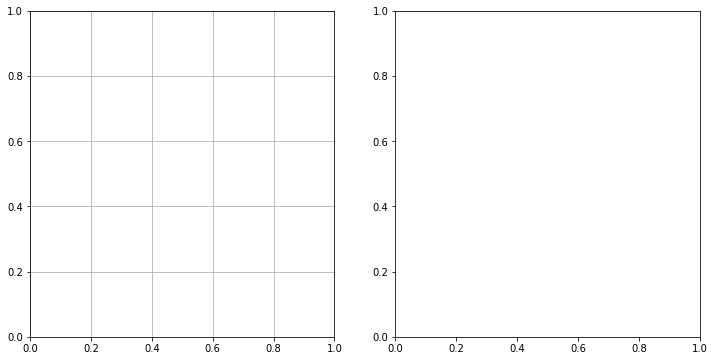

In [17]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

In [187]:
np.ravel(dnn.predict(X_valid))

array([0.337165  , 0.33813494, 0.34095788, 0.34239393, 0.33329833,
       0.34421083, 0.3387261 , 0.33894312, 0.3414331 , 0.34130478,
       0.33208334, 0.33778822, 0.34628335, 0.34039393, 0.33600765,
       0.34061933, 0.33606702, 0.3513162 , 0.3398225 , 0.3424525 ,
       0.3409766 , 0.32812676, 0.33804864, 0.34513864, 0.33702117,
       0.34089005, 0.33875608, 0.3396973 , 0.3380875 , 0.33712077,
       0.3341869 , 0.33875692, 0.33594385, 0.3404556 , 0.3375757 ,
       0.3422922 , 0.33802232, 0.33699304], dtype=float32)

In [189]:
y_pred = dnn.predict(X_valid)

# plot_confusion_matrix(np.ravel(y_valid), np.ravel(y_pred), np.array(["HR", "LR"]))

### Using elu

In [172]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid), class_weight=class_weight,
                  epochs=100, batch_size=10, verbose=1)

Train on 342 samples, validate on 38 samples
Epoch 1/100
342/342 [==============================] - 0s 892us/step - loss: 8.6136 - acc: 0.5058 - val_loss: 8.3087 - val_acc: 0.5789
Epoch 2/100
342/342 [==============================] - 0s 96us/step - loss: 8.2633 - acc: 0.5468 - val_loss: 8.0529 - val_acc: 0.6053
Epoch 3/100
342/342 [==============================] - 0s 91us/step - loss: 8.0046 - acc: 0.5760 - val_loss: 7.8185 - val_acc: 0.5526
Epoch 4/100
342/342 [==============================] - 0s 94us/step - loss: 7.7666 - acc: 0.5994 - val_loss: 7.5965 - val_acc: 0.5789
Epoch 5/100
342/342 [==============================] - 0s 93us/step - loss: 7.5416 - acc: 0.6228 - val_loss: 7.3794 - val_acc: 0.6316
Epoch 6/100
342/342 [==============================] - 0s 92us/step - loss: 7.3214 - acc: 0.6287 - val_loss: 7.1780 - val_acc: 0.6316
Epoch 7/100
342/342 [==============================] - 0s 91us/step - loss: 7.1325 - acc: 0.6082 - val_loss: 6.9927 - val_acc: 0.6316
Epoch 8/100
342/

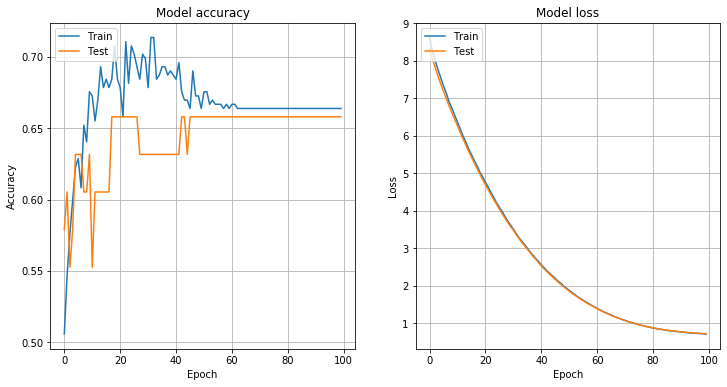

38/38 [==============================] - 0s 39us/step
Loss:0.725, Acc:0.6579


In [173]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

### Using SMOTE

Using SMOTE


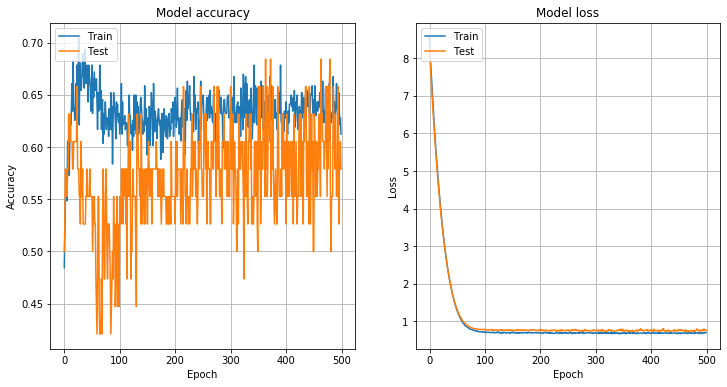

In [160]:
print("Using SMOTE")
X_train,y_train = SMOTE(random_state=RANDOM_STATE).fit_resample(train_data,np.ravel(train_labels)) # Both are np arrays now
X_train = ZScaler.transform(X_train)
y_train = y_train.reshape(-1,1)

class_weight=None
dnn_Mah = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
history = dnn_Mah.fit(X_train, y_train, validation_data=(X_valid,y_valid), class_weight=class_weight,
                  epochs=500, batch_size=10, verbose=0)
plot_history(history)

In [161]:
dnn_Mah.evaluate(X_valid,y_valid)

38/38 [==============================] - 0s 96us/step


[0.7657423772309956, 0.5789473684210527]